In [1]:
import scanpy as sc
import tcri
import pandas as pd
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell
import os

In [ ]:
### Data Download
# adata = sc.read("/Users/ceglian/Data/tcri/zhang/matrix.mtx")
# meta = pd.read_csv("/Users/ceglian/Data/tcri/zhang/GSE179994_Tcell.metadata.tsv",sep="\t")

###

In [3]:
# adata = sc.read("/Users/ceglian/data/tcri/zhang.h5ad")
# meta = sc.read("/Users/ceglian/cd8_zhang.h5ad")
# adata = sc.read("/Users/ceglian/Data/tcri/zhang/matrix.mtx")
# meta = pd.read_csv("/Users/ceglian/Data/tcri/zhang/GSE179994_Tcell.metadata.tsv",sep="\t")
# meta
# adata.write("/Users/ceglian/Data/tcri/zhang/data.h5ad")
# adata = adata.T
# # meta.index = meta["cellid"]
# # meta = meta[["patient","sample","celltype","cluster"]]
# adata.obs = meta
# sct = pd.read_csv("/Users/ceglian/Data/tcri/zhang/GSE179994_all.scTCR.tsv",sep="\t")
# sctd = dict(zip(sct["CellName"],sct["CDR3_nt(Alpha1)"]))
# ct = []
# for x in adata.obs.index:
#     if x in sctd:
#         ct.append(sctd[x])
#     else:
#         ct.append("None")
# adata.obs["trb"] = ct
# adata = adata[adata.obs["trb"] != "None"]
adata = sc.read("/Users/ceglian/Data/tcri/zhang/zhang.h5ad")
# odata = sc.read("/Users/ceglian/data/tcri/zhang.h5ad")
# p = [x.split(".")[0].replace("tr","").replace("ut","") for x in odata.obs["orig.ident"]]
# resd = dict(zip(p,odata.obs['Response']))
# ct = []
# for x in adata.obs["patient"]:
#     if x in resd:
#         ct.append(resd[x])
#     else:
#         ct.append("Unspecified")
# adata.obs["ct"] = ct
# ndata = adata[adata.obs["ct"] != "Unspecified"]
# set(ndata.obs['ct'])
# adata.obs['response'] = adata.obs["ct"]
adata

AnnData object with n_obs × n_vars = 77030 × 19790
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb'

In [4]:
meta = """P001.pre.01	Yes
P001.post.01	Yes
P001.post.02	Yes
P001.post.03	No
P002	-
P003	-
P004	-
P005	-
P006	-
P007	-
P008	-
P009	-
P010.pre.01	Yes
P010.post.01	Yes
P011	-
P012	-
P013.pre.01	Yes
P013.post.01	Yes
P013.post.03	No
P014	-
P015	-
P016	-
P017	-
P018	-
P019.pre.01	Yes
P019.post.01	Yes
P020	-
P021	-
P022	-
P023	-
P024	-
P025	-
P026	-
P027	-
P028	-
P029.pre.01	Yes
P029.post.01	Yes
P030.pre.01	Yes
P030.post.01	Yes
P033.pre.01	Yes
P033.post.01	Yes
P034	-
P035.pre.01	Yes
P035.post.01	Yes
P036.post.01	No
P037.post.01	No
P038.post.01	No""".splitlines()
respd = dict()
for x in meta:
    x = x.split("\t")
    respd[x[0].replace("P0","P").replace(".01",".1").replace(".02",".2").replace(".03",".3").replace("P0","P")] = x[1]
print(respd)
response = []
for x in adata.obs["sample"]:
    if x in respd:
        response.append(respd[x])
    else:
        if x + ".1" in respd:
            response.append(respd[x+".1"])
        else:
            response.append("None")
adata.obs["response"] = response

{'P1.pre.1': 'Yes', 'P1.post.1': 'Yes', 'P1.post.2': 'Yes', 'P1.post.3': 'No', 'P2': '-', 'P3': '-', 'P4': '-', 'P5': '-', 'P6': '-', 'P7': '-', 'P8': '-', 'P9': '-', 'P10.pre.1': 'Yes', 'P10.post.1': 'Yes', 'P11': '-', 'P12': '-', 'P13.pre.1': 'Yes', 'P13.post.1': 'Yes', 'P13.post.3': 'No', 'P14': '-', 'P15': '-', 'P16': '-', 'P17': '-', 'P18': '-', 'P19.pre.1': 'Yes', 'P19.post.1': 'Yes', 'P20': '-', 'P21': '-', 'P22': '-', 'P23': '-', 'P24': '-', 'P25': '-', 'P26': '-', 'P27': '-', 'P28': '-', 'P29.pre.1': 'Yes', 'P29.post.1': 'Yes', 'P30.pre.1': 'Yes', 'P30.post.1': 'Yes', 'P33.pre.1': 'Yes', 'P33.post.1': 'Yes', 'P34': '-', 'P35.pre.1': 'Yes', 'P35.post.1': 'Yes', 'P36.post.1': 'No', 'P37.post.1': 'No', 'P38.post.1': 'No'}


In [5]:
adata.obs["response"]

cellid
P1.ut.AAACCTGGTGGTACAG-1       Yes
P1.ut.AAACCTGTCACGGTTA-1       Yes
P1.ut.AAACCTGTCCGCTGTT-1       Yes
P1.ut.AAACGGGAGTCCCACG-1       Yes
P1.ut.AAACGGGAGTTAGCGG-1       Yes
                              ... 
P38.tr.1.TTTGCGCAGCTAGTTC-1     No
P38.tr.1.TTTGCGCGTTGCCTCT-1     No
P38.tr.1.TTTGCGCTCATCGATG-1     No
P38.tr.1.TTTGGTTCACGGTAAG-1     No
P38.tr.1.TTTGTCAGTCACTTCC-1     No
Name: response, Length: 77030, dtype: object

In [6]:
genes = pd.read_csv("/Users/ceglian/Data/tcri/zhang/genes.csv")
symbols = genes["x"].tolist()
gene_names = []
for g in adata.var.index.tolist():
    gene_names.append(symbols[int(g)])
adata.var.index = gene_names
adata.var

Empty DataFrame
Columns: []
Index: [OR4F5, OR4F29, OR4F16, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, HES4, ISG15, AGRN, RNF223, C1orf159, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, UBE2J2, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20, ANKRD65, TMEM88B, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, FNDC10, MIB2, MMP23B, CDK11B, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, CALML6, TMEM52, CFAP74, GABRD, PRKCZ, FAAP20, SKI, MORN1, RER1, PEX10, PLCH2, PANK4, HES5, TNFRSF14, MMEL1, TTC34, ACTRT2, PRDM16, ARHGEF16, MEGF6, TPRG1L, WRAP73, TP73, CCDC27, SMIM1, LRRC47, CEP104, DFFB, C1orf174, AJAP1, NPHP4, KCNAB2, CHD5, RPL22, RNF207, ICMT, HES3, GPR153, ACOT7, HES2, ESPN, TNFRSF25, PLEKHG5, NOL9, TAS1R1, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1, VAMP3, ...]

[19790 rows x 0 columns]

In [7]:
#any without signed mi were  false
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1.5
mutual_information = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}.p".format(signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
embedding_size     = 100
alpha              = 0.08
beta               = 0.02
gain               = 10
vector_file        = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}_{}_{}_{}_{}.vec".format(embedding_size, alpha, beta, gain, signed_mi, init_ortho)
print(vector_file)
retrain            = True
annotated_h5ad     = "/Users/ceglian/Data/tcri/zhang_annotated.h5ad"
device             = "cpu"

/Users/ceglian/Data/tcri/zhang_cd8_True_15.p
/Users/ceglian/Data/tcri/zhang_cd8_100_0.08_0.02_10_True_True.vec


In [8]:
genes = [x for x in adata.var.index.tolist()]
genes = [x for x in genes if "TRAV" not in x]
genes = [x for x in genes if "TRAJ" not in x]
genes = [x for x in genes if "TRAD" not in x]


genes = [x for x in genes if "TRBV" not in x]
genes = [x for x in genes if "TRBJ" not in x]
genes = [x for x in genes if "TRBD" not in x]

genes = [x for x in genes if "TRGV" not in x]
genes = [x for x in genes if "TRGJ" not in x]
genes = [x for x in genes if "TRGD" not in x]

genes = [x for x in genes if "TRDV" not in x]
genes = [x for x in genes if "TRDJ" not in x]
genes = [x for x in genes if "TRDD" not in x]
adata = adata[:,genes]

adata = spell.pp.remove_meaningless_genes(adata)
adata.var

Empty DataFrameView
Columns: []
Index: [OR4F5, OR4F29, OR4F16, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, HES4, ISG15, AGRN, RNF223, C1orf159, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, UBE2J2, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, ANKRD65, TMEM88B, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, FNDC10, MIB2, MMP23B, CDK11B, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, CALML6, TMEM52, CFAP74, GABRD, PRKCZ, FAAP20, SKI, MORN1, RER1, PEX10, PLCH2, PANK4, HES5, TNFRSF14, MMEL1, TTC34, ACTRT2, PRDM16, ARHGEF16, MEGF6, TPRG1L, WRAP73, TP73, CCDC27, SMIM1, LRRC47, CEP104, DFFB, C1orf174, AJAP1, NPHP4, KCNAB2, CHD5, RNF207, ICMT, HES3, GPR153, ACOT7, HES2, ESPN, TNFRSF25, PLEKHG5, NOL9, TAS1R1, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1, VAMP3, PER3, UTS2, ...]

[19264 rows x 0 columns]

In [9]:

adata = adata[adata.obs["trb"]!=""]
adata = adata[adata.obs["trb"]!="nan"]
adata = adata[adata.obs["trb"]!="Other"]
adata.var

Empty DataFrameView
Columns: []
Index: [OR4F5, OR4F29, OR4F16, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, HES4, ISG15, AGRN, RNF223, C1orf159, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, UBE2J2, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, ANKRD65, TMEM88B, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, FNDC10, MIB2, MMP23B, CDK11B, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, CALML6, TMEM52, CFAP74, GABRD, PRKCZ, FAAP20, SKI, MORN1, RER1, PEX10, PLCH2, PANK4, HES5, TNFRSF14, MMEL1, TTC34, ACTRT2, PRDM16, ARHGEF16, MEGF6, TPRG1L, WRAP73, TP73, CCDC27, SMIM1, LRRC47, CEP104, DFFB, C1orf174, AJAP1, NPHP4, KCNAB2, CHD5, RNF207, ICMT, HES3, GPR153, ACOT7, HES2, ESPN, TNFRSF25, PLEKHG5, NOL9, TAS1R1, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1, VAMP3, PER3, UTS2, ...]

[19264 rows x 0 columns]

In [10]:
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
adata.var

100%|██████████| 19264/19264 [00:14<00:00, 1299.21it/s]


entropy
ISG15     1.858449
TNFRSF18  2.115975
TNFRSF4   2.379996
ENO1      1.572219
ID3       1.554085
...            ...
GTSE1     1.564562
SAMSN1    1.791777
SOD1      2.123625
MX1       1.500491
S100B     1.834191

[356 rows x 1 columns]

In [11]:
tcri.pp.register_clonotype_key(adata,"trb")

In [12]:
dataset = GeneVectorDataset(adata,load_expression=True,signed_mi=signed_mi,device=device)

Running...
Loading Expression.
Indexing expression.


100%|██████████| 15252980/15252980 [00:07<00:00, 1953176.17it/s]


Finished.


In [14]:
vector_file

'/Users/ceglian/Data/tcri/zhang_cd8_100_0.08_0.02_10_True_True.vec'

In [13]:
mutual_information

'/Users/ceglian/Data/tcri/zhang_cd8_True_15.p'

In [184]:
import pickle
# if os.path.exists(vector_file):
#     retrain = False
#     print("found previous model.")
if retrain:
    if os.path.exists(mutual_information):
        dataset.mi_scores = pickle.load(open(mutual_information,"rb"))
    print(len(dataset.mi_scores),len(adata.var.index.tolist()))
    cmps = GeneVector(dataset,
                        output_file=vector_file,
                        emb_dimension=embedding_size,
                        gain=gain,
                        init_ortho=init_ortho,
                        device=device)
if not os.path.exists(mutual_information):
    pickle.dump(dict(dataset.mi_scores),open(mutual_information,"wb"))

356 356
*****************
Loading Dataset.
*****************



100%|██████████| 356/356 [00:00<00:00, 638.68it/s]


MI Loaded.
Loading Batches for Training.


100%|██████████| 63190/63190 [00:00<00:00, 424654.75it/s]

Ready to train.


**** Epoch 0 	Loss: 79886.10156
**** Epoch 200 	Loss: 1335.52617
**** Epoch 400 	Loss: 59.83382
**** Epoch 600 	Loss: 48.6996
**** Epoch 800 	Loss: 45.22297
**** Epoch 1000 	Loss: 43.19513
**** Epoch 1200 	Loss: 41.30972
**** Epoch 1400 	Loss: 38.78155
**** Epoch 1600 	Loss: 36.60144
**** Epoch 1800 	Loss: 34.80988
**** Epoch 2000 	Loss: 33.13453
**** Epoch 2200 	Loss: 31.15081
**** Epoch 2400 	Loss: 28.54341
**** Epoch 2600 	Loss: 25.33793
**** Epoch 2800 	Loss: 22.01456
**** Epoch 3000 	Loss: 19.40747
**** Epoch 3200 	Loss: 17.74032
**** Epoch 3400 	Loss: 16.75864
**** Epoch 3600 	Loss: 16.63662
**** Epoch 3800 	Loss: 16.57364
**** Epoch 4000 	Loss: 16.52
**** Epoch 4200 	Loss: 16.4788
**** Epoch 4400 	Loss: 16.44391
**** Epoch 4600 	Loss: 16.41613
**** Epoch 4800 	Loss: 16.39221
**** Epoch 5000 	Loss: 16.37353
**** Epoch 5200 	Loss: 16.36392
Training complete!
Loading average of 1st and 2nd weights.


100%|██████████| 356/356 [00:00<00:00, 3041083.96it/s]


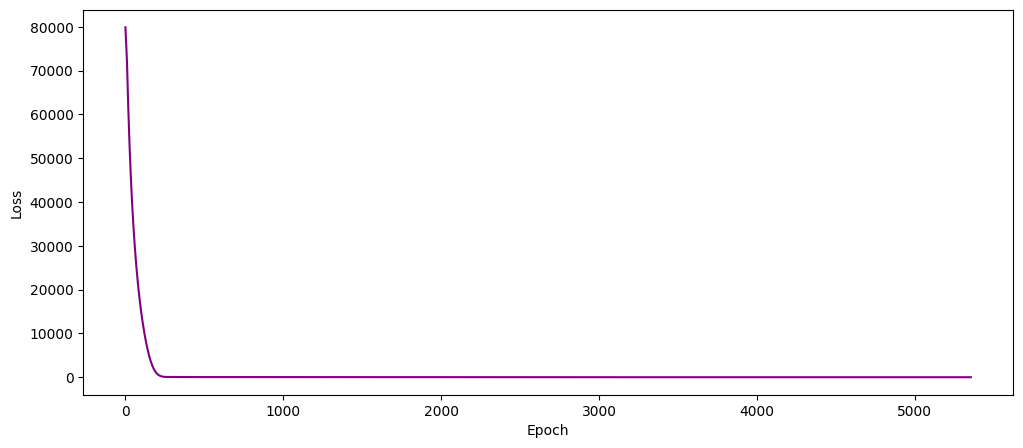

In [185]:
if retrain:
    cmps.train(100000,threshold=1e-5,alpha=alpha, beta=beta, update_interval=200)
    embed = GeneEmbedding(vector_file, dataset, vector="average")
    cmps.plot()

In [186]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
adata

Loading average of 1st and 2nd weights.


100%|██████████| 356/356 [00:00<00:00, 2583342.95it/s]


100%|██████████| 15252980/15252980 [00:33<00:00, 459733.25it/s]


Generating Cell Vectors.


100%|██████████| 77030/77030 [00:06<00:00, 11447.13it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


AnnData object with n_obs × n_vars = 77030 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'

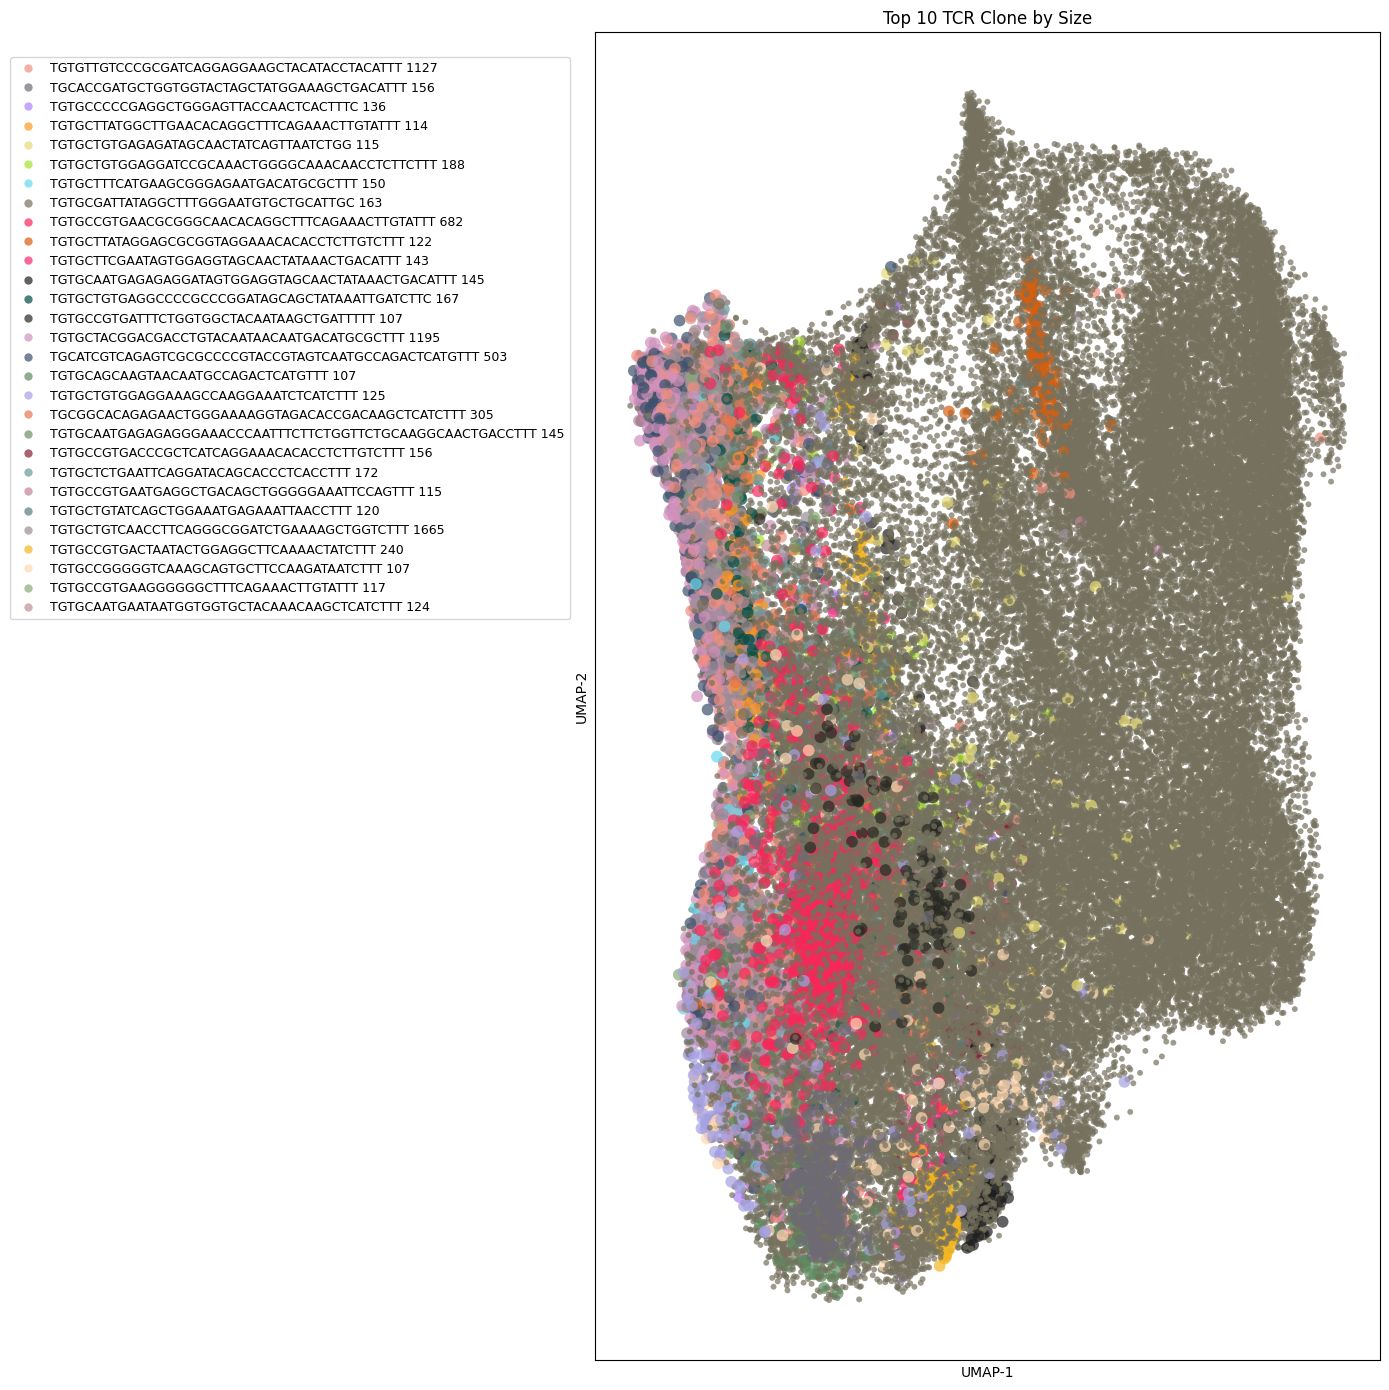

In [187]:
tcri.pl.clone_umap(adata,top_n=30,size=5,figsize=(14,14))

In [188]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [189]:
markers = dict()
markers["Naive"] = ["IL7R"]
markers["Memory"] = ["GZMK"]
markers["Activated"] = ["GZMB"]
markers["Dysfunctional"] = ["CXCL13"]
adata, dist = cembed.phenotype_probability(adata, markers, method="normalized_exponential",temperature=0.01, return_distances=True)

Using Normalized Exponential (Temp: 0.01)
Computing similarities for Naive
Markers: IL7R


100%|██████████| 77030/77030 [00:00<00:00, 78137.03it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 77030/77030 [00:00<00:00, 77631.26it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 77030/77030 [00:00<00:00, 77803.51it/s]


Computing similarities for Dysfunctional
Markers: CXCL13


100%|██████████| 77030/77030 [00:01<00:00, 76765.31it/s]


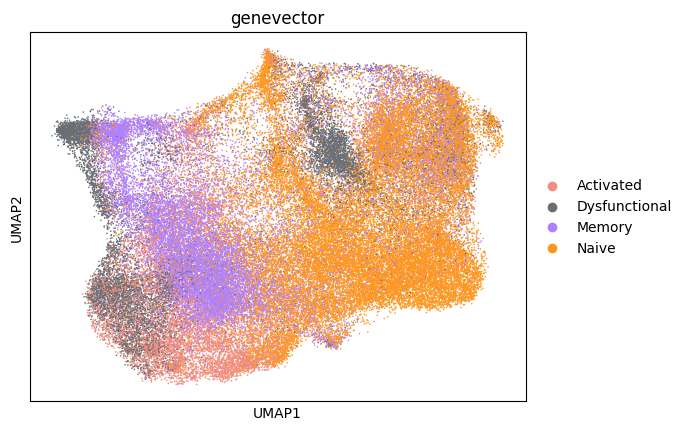

In [220]:
sc.pl.umap(adata,color="genevector",s=5,save="zhang.pdf")
!cp figures/umapzhang.pdf ~

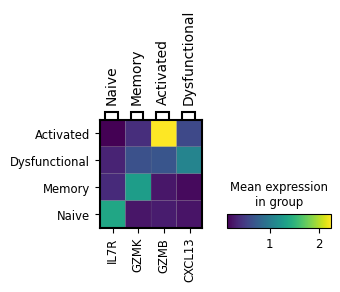

In [132]:
sc.pl.matrixplot(adata,markers,groupby="genevector")

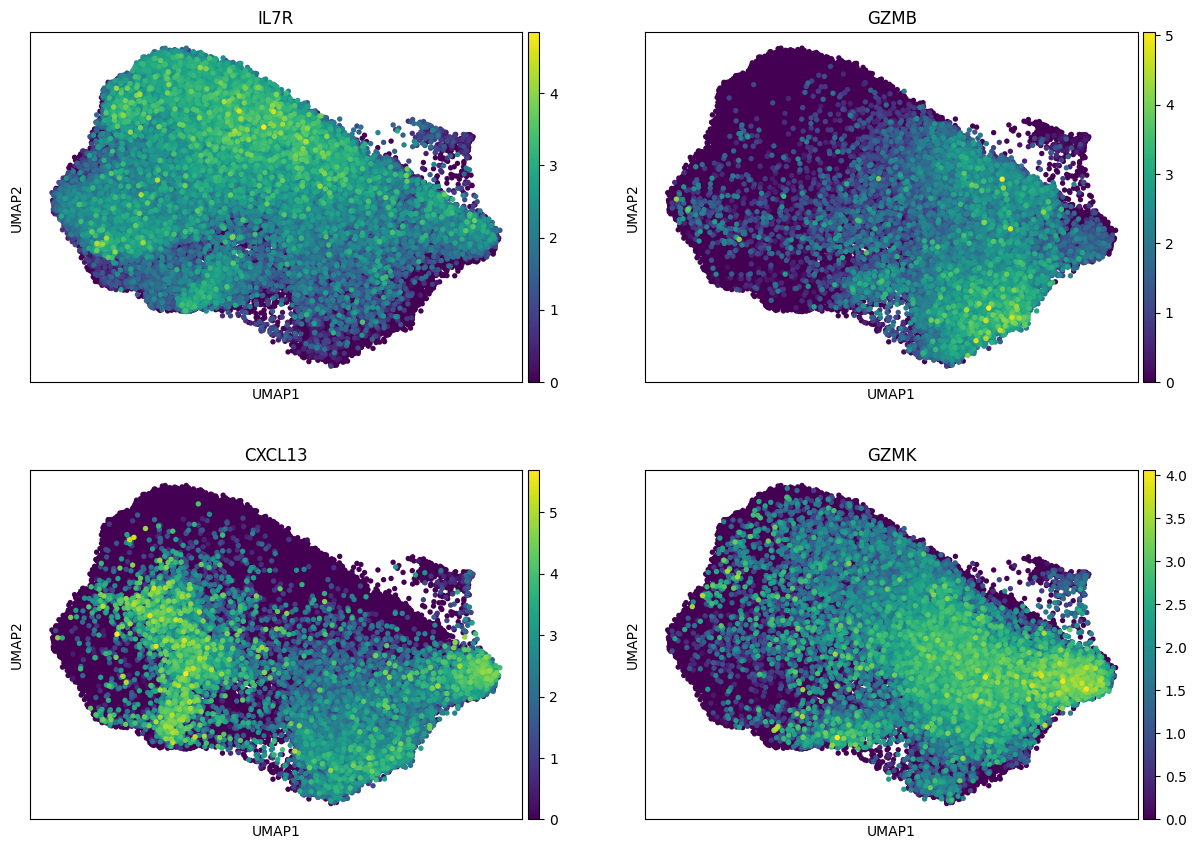

In [133]:
sc.pl.umap(adata,color=["IL7R","GZMB","CXCL13","GZMK"],ncols=2,s=60)

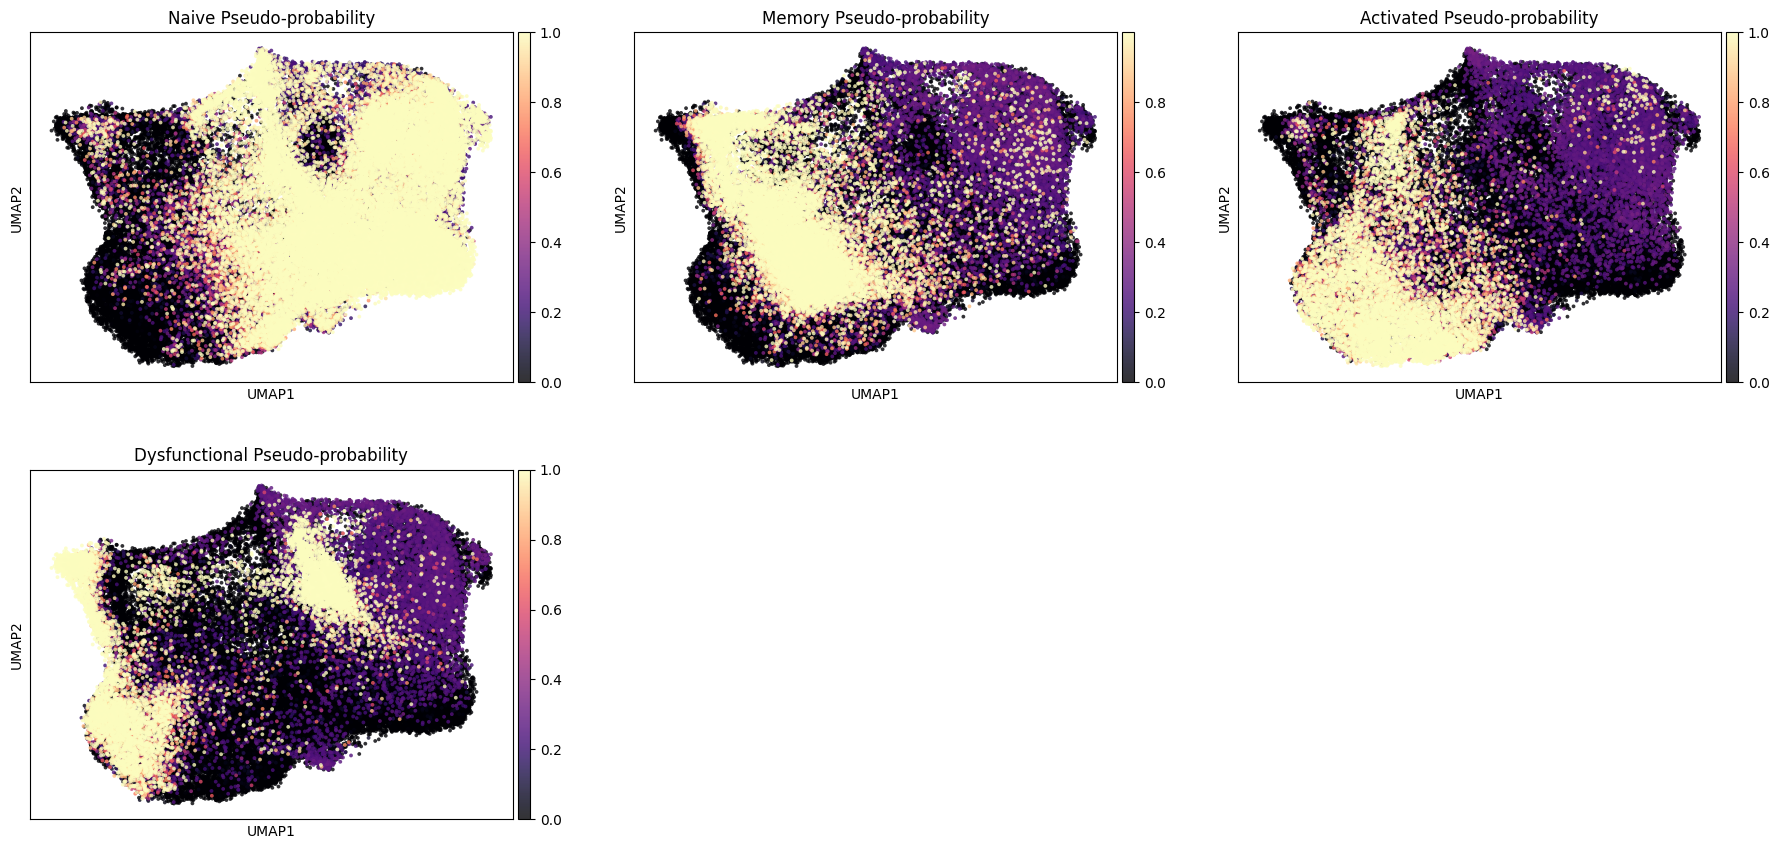

In [222]:

cembed.plot_probabilities(adata)
!cp figures/umapprobs.pdf ~

In [193]:
tcri.pp.clone_size(adata)

In [201]:
tcri.pp.register_phenotype_key(adata,"genevector")

In [199]:
timepoint = []
for x in adata.obs["sample"]:
    tp = ".".join(x.split(".")[1:])
    timepoint.append(tp)
adata.obs["timepoint"] = timepoint

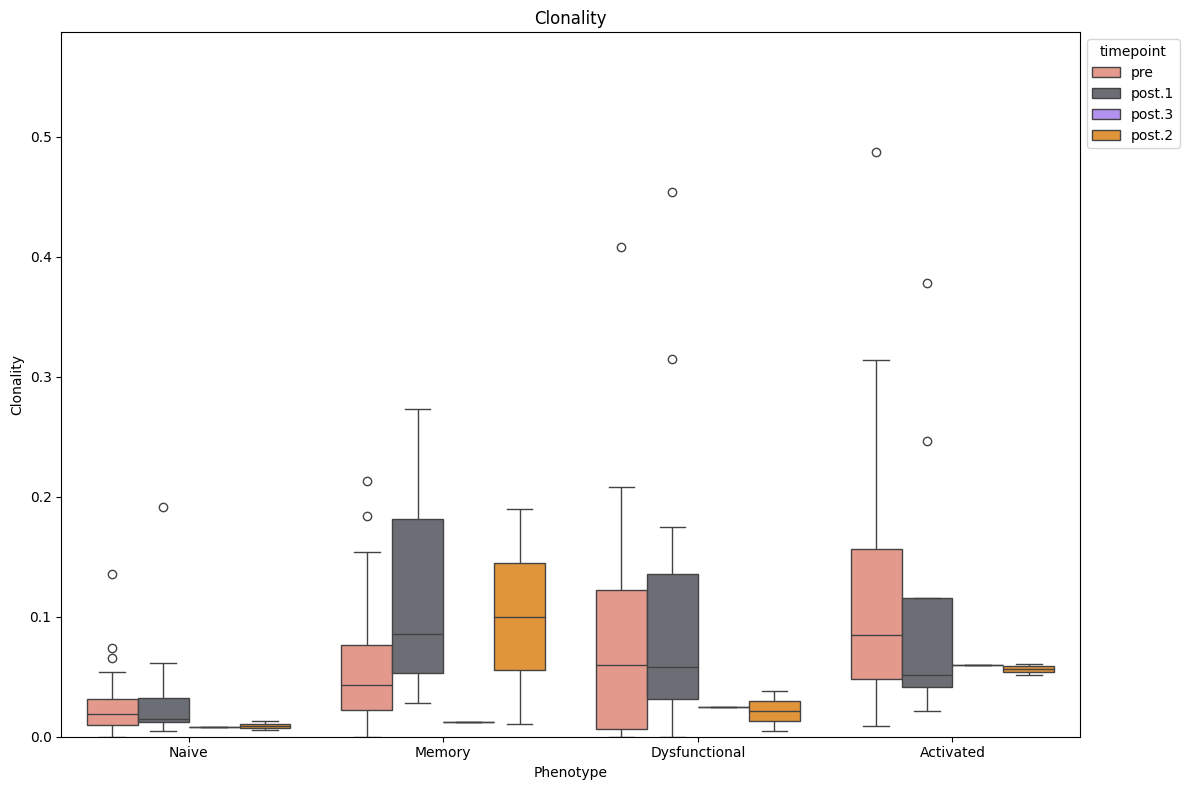

In [221]:
#adata = adata[adata.obs['response']!="Unspecified"]
tcri.pl.clonality(adata,groupby="patient",figsize=(12,8),splitby="timepoint")
plt.savefig("/Users/ceglian/clonality.pdf")

<Axes: title={'center': 'Clonotypic Entropy'}, xlabel='Phenotype', ylabel='Clonotypic Entropy'>

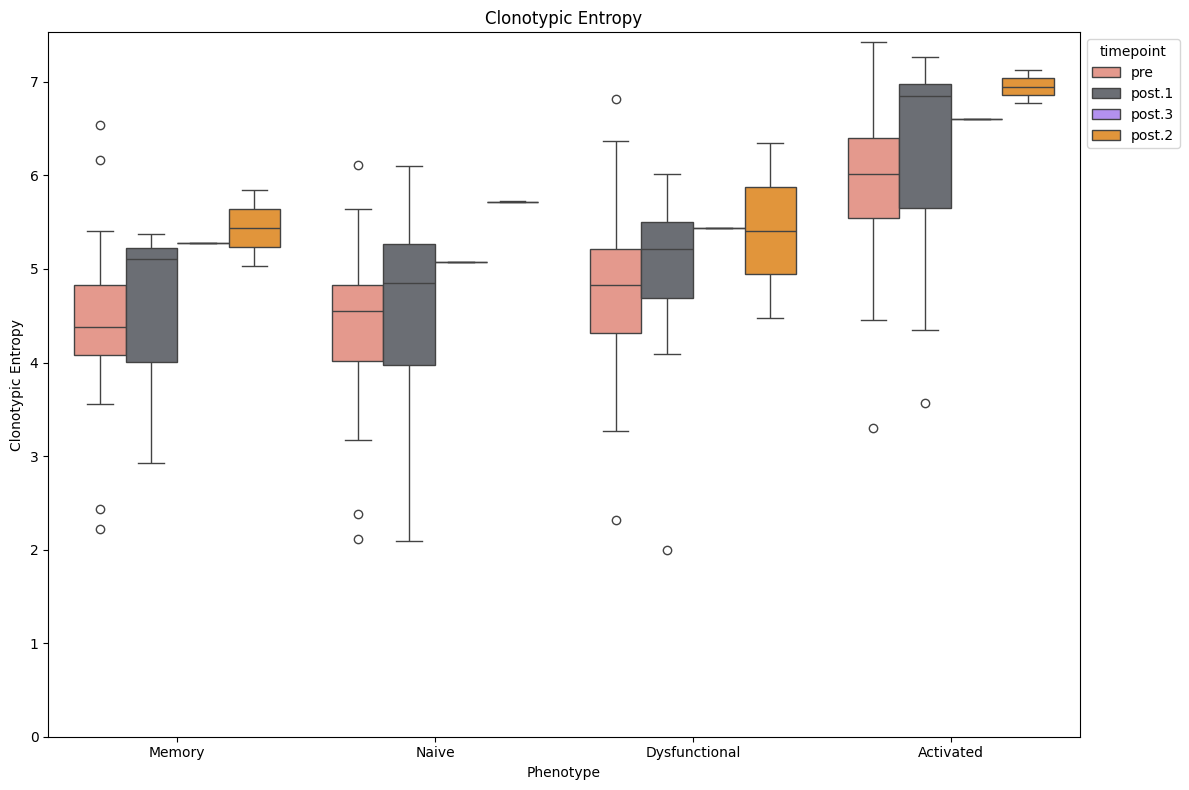

In [223]:
#adata = adata[adata.obs['response']!="Unspecified"]
tcri.pl.clonotypic_entropies(adata,groupby="patient",figsize=(12,8),method="probabilistic",splitby="timepoint",normalized=False)

100%|██████████| 35/35 [00:00<00:00, 52.72it/s]


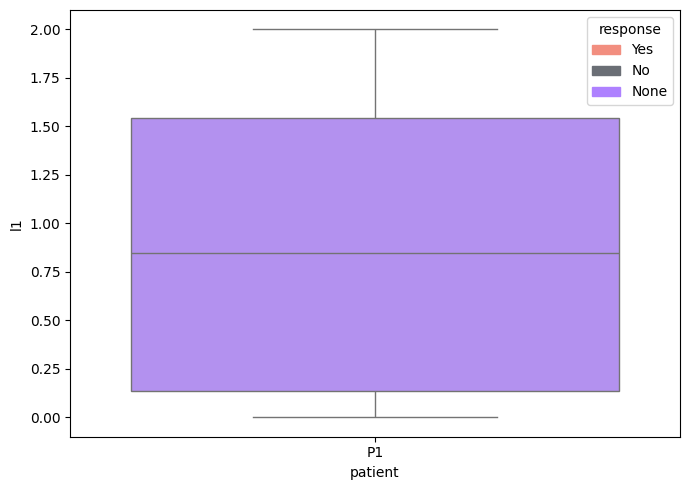

In [207]:
tcri.pl.flux(adata, key="timepoint", from_this="pre", to_that="post.3", groupby="patient",paint="response", method="probabilistic", distance_metric="l1",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_l1.pdf")

100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


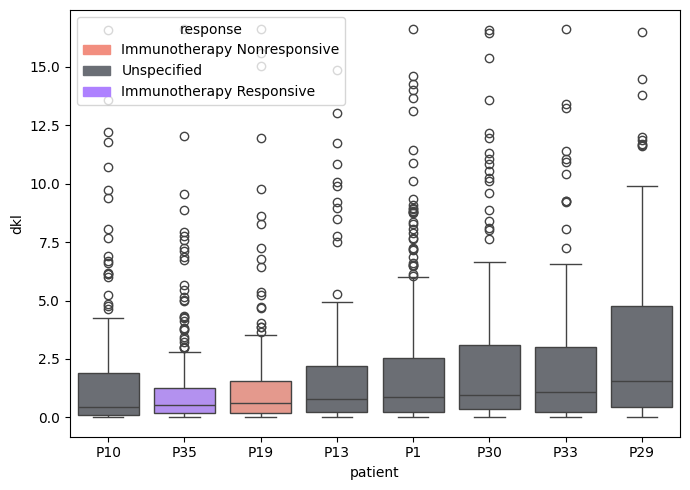

In [151]:
import matplotlib.pyplot as plt
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="patient", method="probabilistic", distance_metric="dkl",paint="response",figsize=(7,5))
plt.savefig("/Users/ceglian/flux_l1.pdf")

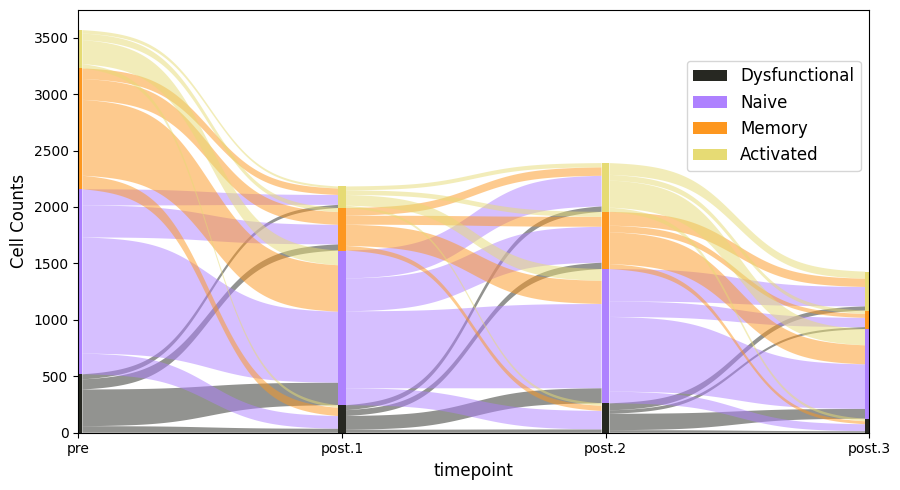

In [213]:
sub = adata[adata.obs["patient"] == "P1"]
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=False)
plt.savefig("/Users/ceglian/zhang_p1.pdf")

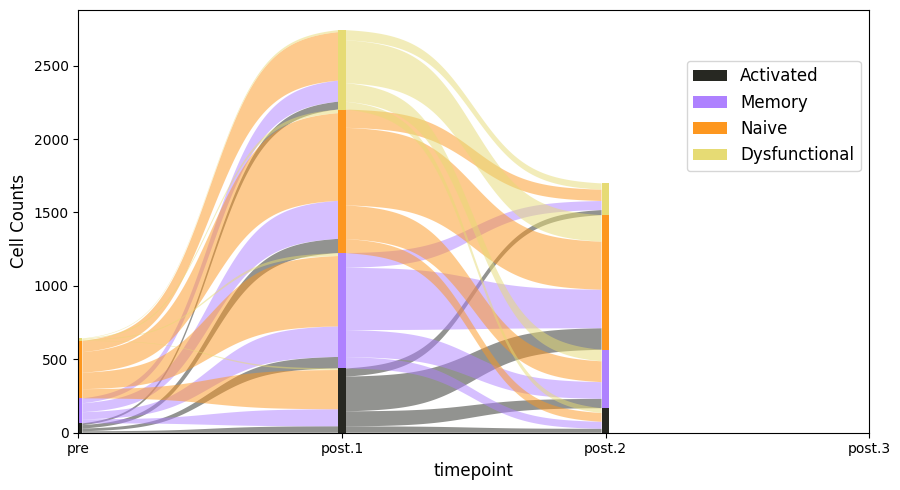

In [215]:
sub = adata[adata.obs["patient"] == "P13"]
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=False)
plt.savefig("/Users/ceglian/zhang_p13.pdf")

100%|██████████| 35/35 [00:01<00:00, 30.22it/s]


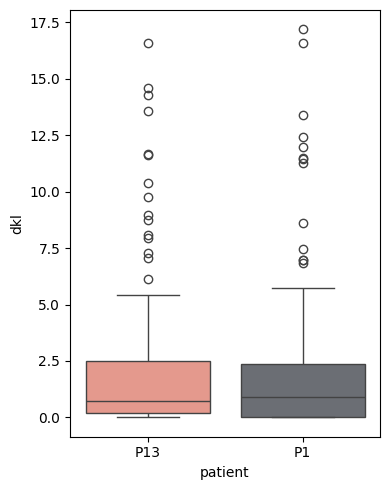

In [218]:
tcri.pl.flux(adata, key="timepoint", from_this="post.1", to_that="post.2", groupby="patient", method="probabilistic", distance_metric="dkl",figsize=(4,5))
plt.savefig("/Users/ceglian/dkl_response.pdf")

100%|██████████| 3/3 [00:18<00:00,  6.14s/it]


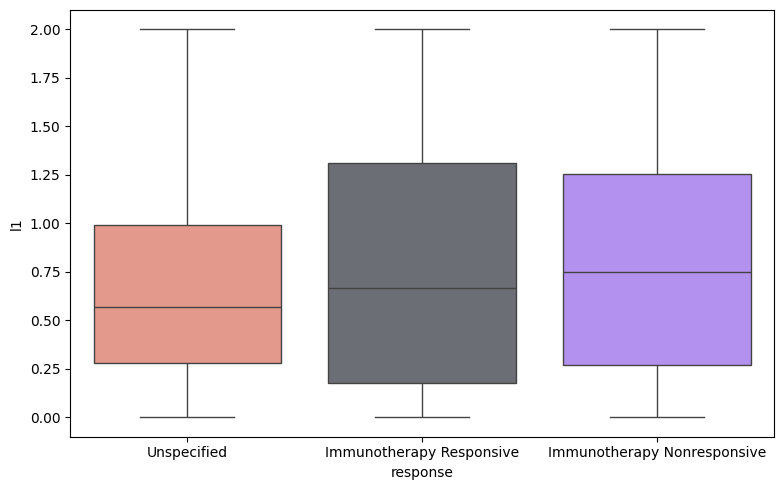

In [158]:
tcri.pl.flux(adata, key="treatment", from_this="pre", to_that="post", groupby="response", method="probabilistic", distance_metric="l1",figsize=(8,5))
plt.savefig("/Users/ceglian/dkl_response.pdf")